# Sentiment analysis
### Machine learning course project
#### Marta Kałużna, Szymon Czop

Sentiment analysis is mostly used to describe the emotions about the given topic.  It can be anything, starting from reviews of the movies and twitters, ending with opinions written in social media by a certain person.
It is a powerful tool to analyze current and future trends and opinions. In our report, we took on the workshop data from IMDb movie reviews. In the beginning, we made some data exploration and calculated some ratios to find any dependencies between variables (certain words in our case). We were trying to find out if there are words strictly connected with negative or positive emotions. To play with the number of occurrences of a certain word we used Zipf's law. Then we tried to find which approach of pre-processing data is the best for logistic regression or naive Bayes.  In the end, we compared some common ML models in terms of accuracy in test data and their time of evaluation.

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 

In [2]:
import nltk 
import string
import re
from nltk.corpus import stopwords
ps = nltk.PorterStemmer()
stopword = nltk.corpus.stopwords.words('english')
def clean_text(text):
    text_lc = "".join([word.lower() for word in text if word not in string.punctuation]) # remove puntuation
    text_rc = re.sub('[0-9]+', '', text_lc)
    tokens = re.split('\W+', text_rc)    # tokenization
    text = [ps.stem(word) for word in tokens if word not in stopword]  # remove stopwords and stemming
    return text


In [3]:
import re
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer
tok = WordPunctTokenizer()

pat1 = r'@[A-Za-z0-9_]+'
pat2 = r'https?://[^ ]+'
combined_pat = r'|'.join((pat1, pat2))
www_pat = r'www.[^ ]+'
negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

def cleaner(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    try:
        bom_removed = souped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        bom_removed = souped
    stripped = re.sub(combined_pat, '', bom_removed)
    stripped = re.sub(www_pat, '', stripped)
    lower_case = stripped.lower()
    neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], lower_case)
    letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)
    words = [x for x  in tok.tokenize(letters_only) if len(x) > 1]
    return (" ".join(words)).strip()

# IMDb reviews

In [4]:
df = pd.read_csv("IMDB_sample.csv")

### Loading and cleaning data

Let's have a look at the data we are going to work on. Review column is a text that sentiment we will analyze, label column tells us how each review is classified. Zero stands for negative, and one for the positive review. The first column doesn't give us any information so we will drop it.

In [5]:


df.head() # 1 positive , 0 negative
#df.label.value_counts()
#df.shape


Unnamed: 0                                             review  label
0       18245  This short spoof can be found on Elite's Mille...      0
1       19801  A singularly unfunny musical comedy that artif...      0
2        3222  An excellent series, masterfully acted and dir...      1
3        6010  The master of movie spectacle Cecil B. De Mill...      1
4       16355  I was gifted with this movie as it had such a ...      0

In [6]:
clean_texts = []
for i in range(0,df.shape[0]):                                                                    
    clean_texts.append(cleaner(df['review'][i]))

In [7]:

clean_df = pd.DataFrame(clean_texts,columns=['text'])
clean_df.head()


text
0  this short spoof can be found on elite millenn...
1  singularly unfunny musical comedy that artific...
2  an excellent series masterfully acted and dire...
3  the master of movie spectacle cecil de mille g...
4  was gifted with this movie as it had such grea...

In [8]:
clean_df["text2"] =df['review'].apply(lambda x : clean_text(x))

The first step after downloading data is cleaning.  We cleaned data using two different approaches. The first one is less strict so we just lowered all letters, get rid of commas and " 's " at the end of words, this part can be found in column "text". In the second one, beyond the action that is described above, we use lemmatization and stemming to reduce the number of words to analyze. They can be found in the column "text2".
This more advanced approach reduces the number of words in data but takes a lot of time to clean data. We will check if it is worthwhile in further experiments.

In [9]:
clean_df['target'] = df.label
clean_df.head()

text  \
0  this short spoof can be found on elite millenn...   
1  singularly unfunny musical comedy that artific...   
2  an excellent series masterfully acted and dire...   
3  the master of movie spectacle cecil de mille g...   
4  was gifted with this movie as it had such grea...   

                                               text2  target  
0  [short, spoof, found, elit, millennium, edit, ...       0  
1  [singularli, unfunni, music, comedi, artifici,...       0  
2  [excel, seri, master, act, direct, unlov, told...       1  
3  [master, movi, spectacl, cecil, b, de, mill, g...       1  
4  [gift, movi, great, premis, friendship, three,...       0

##### Checking for NA values 

Sometimes after cleaning whole reviews may be erazed. It happens when they are just emoji or made only by stopwords. In this case, we would have ''Nan-s". Those reviews should be excluded from training and testing data. For our luck this is not the case in our dataset, there is no need for further data cleaning.

In [25]:
clean_df.info()
clean_df[clean_df.isnull().any(axis=1)]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7501 entries, 0 to 7500
Data columns (total 3 columns):
text      7501 non-null object
text2     7501 non-null object
target    7501 non-null int64
dtypes: int64(1), object(2)
memory usage: 175.9+ KB


Empty DataFrame
Columns: [text, text2, target]
Index: []

In [26]:
from wordcloud import WordCloud

### Creating wordclouds

Wordclouds are great as a decoration or headline in presentations, but they don't give us much information in the analysis. The main idea of them is to show which words were used mainly in a negative or positive meaning: the bigger word in the picture, the higher frequency in the data.

In [28]:
neg_rev = clean_df[clean_df.target == 0]
neg_string = []
for t in neg_rev.text:
    neg_string.append(t)
neg_string = pd.Series(neg_string).str.cat(sep=' ')

#### Negative wordcloud

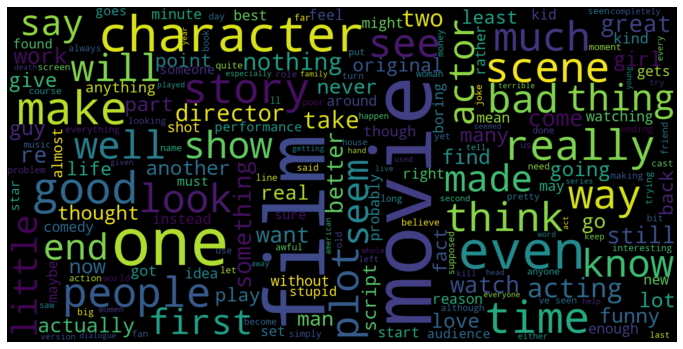

In [32]:
wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(neg_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig('first_negative.png')
plt.show()

#### Positive wordcloud

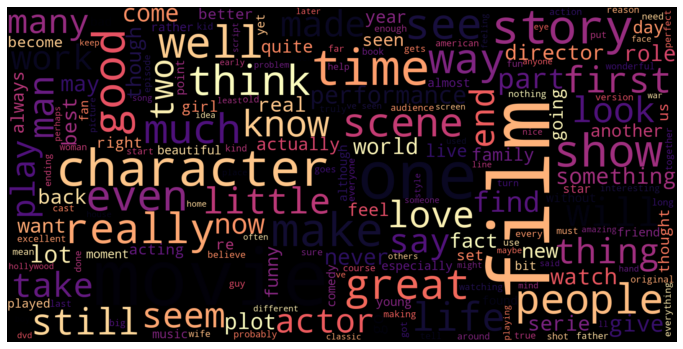

In [34]:

pos_rev = clean_df[clean_df.target == 1]
pos_string = []
for t in pos_rev.text:
    pos_string.append(t)
pos_string = pd.Series(pos_string).str.cat(sep=' ')

wordcloud = WordCloud(width=1600, height=800,max_font_size=200,colormap='magma').generate(pos_string) 
plt.figure(figsize=(12,10)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off") 
plt.savefig('first_positive.png')
plt.show()

As said before word clouds are not the best way to make a verdict on but we can gain some information from them. Nouns like 'movie' or 'character' occur frequently in both clouds so they are not clear about the sentiment that stands behind them.

      
###  Most frequently words and their ratio between positives and negatives

In [41]:
from sklearn.feature_extraction.text import CountVectorizer
countVectorizer = CountVectorizer() 
countVectorizer2 = CountVectorizer(analyzer = clean_text) 
countVector = countVectorizer.fit_transform(clean_df['text'])
countVector2 = countVectorizer2.fit_transform(clean_df['text'])

Difference in the shapes of vectorizer matrices due to the different text cleaning:

In [60]:
[countVector.shape,countVector2.shape]

[(7501, 45032), (7501, 30279)]


We have about 7500 reviews. The number of words that occur in the column 'text' is about 45k. In case of more strict data cleaning used in column 'text2' we have less than 31k of different words.

In [105]:
from IPython.core.display import HTML

def multi_table(table_list):
    ''' Acceps a list of IpyTable objects and returns a table which contains each IpyTable in a cell
    '''
    return HTML(
        '<table><tr style="background-color:white;">' + 
        ''.join(['<td>' + table._repr_html_() + '</td>' for table in table_list]) +
        '</tr></table>'
    )

In [82]:
matrix = countVector.toarray()
neg_matrix = matrix[clean_df.target == 0]
pos_matrix = matrix[clean_df.target == 1]

In [83]:
neg_tf = np.sum(neg_matrix,axis=0)
pos_tf = np.sum(pos_matrix,axis=0)

In [84]:
neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))
term_freq_df = pd.DataFrame([neg,pos],columns=countVectorizer.get_feature_names()).transpose()

In [85]:
term_freq_df.columns = ['negative', 'positive']
term_freq_df['total'] = term_freq_df['negative'] + term_freq_df['positive']
term_freq_df.sort_values(by='total', ascending=False).iloc[:10]

negative  positive   total
the      48519     52181  100700
and      22202     26871   49073
of       20430     22867   43297
to       20412     20165   40577
is       15230     17671   32901
it       14435     14487   28922
in       12973     15283   28256
this     12199     10760   22959
that     11354     10909   22263
not      10783      8447   19230

In [77]:
matrix = countVector2.toarray()

neg_matrix = matrix[clean_df.target == 0]
pos_matrix = matrix[clean_df.target == 1]

neg_tf = np.sum(neg_matrix,axis=0)
pos_tf = np.sum(pos_matrix,axis=0)

neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))

term_freq_df2 = pd.DataFrame([neg,pos],columns=countVectorizer2.get_feature_names()).transpose()
term_freq_df2.columns = ['negative', 'positive']
term_freq_df2['total'] = term_freq_df2['negative'] + term_freq_df2['positive']
#term_freq_df2.sort_values(by='total', ascending=False).iloc[:10]

negative  positive  total
movi         8695      6907  15602
film         6864      7684  14548
one          4054      4316   8370
like         3685      3202   6887
time         2256      2502   4758
good         2202      2427   4629
make         2418      2134   4552
see          2011      2328   4339
get          2364      1967   4331
charact      2167      2136   4303

Now let's have a look at most frequently occurred words and their sentiment context after two different cleaning processes. The below tables are showing the top 10 occurring words from each cleaning approach.

In [87]:
multi_table([term_freq_df.sort_values(by='total', ascending=False).iloc[:10],term_freq_df2.sort_values(by='total', ascending=False).iloc[:10]])

As a comparison, we've considered two approaches to CountVectorizer: 1st - less cleaned data, 2nd - tokenization, removing stopwords and punctuations. We've printed 10 most common used words for those two methods. At first glance, we can notice that every word has almost the same number of negative and positive representations. But in 'non-cleaned' data, these words doesn't make sense in case of sentiment analysis.

 #### Regression as a tool for finding dependencies

To make sure of our previous insights, we will fit regression where we will try to find the correlation between negative and positive frequencies. If we will manage to fit model properly, it means that if words are frequent, they don't carry any valuable information about review sentiment.

Text(0.5, 1.0, 'Negative Frequency vs Positive Frequency cleaned data')

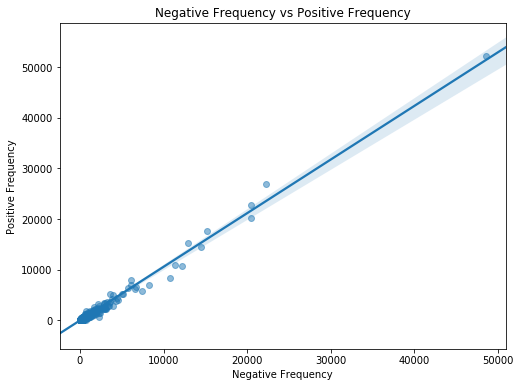

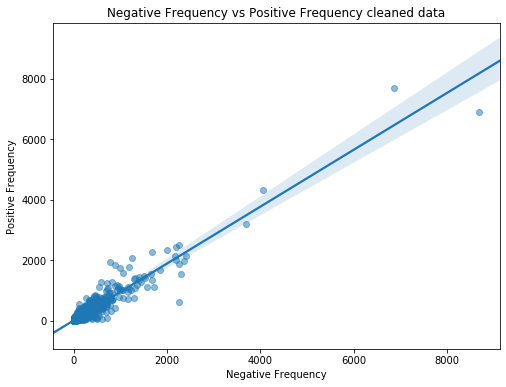

In [108]:
import seaborn as sns 
plt.figure(figsize=(8,6))
#plt.subplot(121)
ax = sns.regplot(x="negative", y="positive",fit_reg=True, scatter_kws={'alpha':0.5},data=term_freq_df)
plt.ylabel('Positive Frequency')
plt.xlabel('Negative Frequency')
plt.title('Negative Frequency vs Positive Frequency')

plt.figure(figsize=(8,6))
#plt.subplot(121)
ax = sns.regplot(x="negative", y="positive",fit_reg=True, scatter_kws={'alpha':0.5},data=term_freq_df2)
plt.ylabel('Positive Frequency')
plt.xlabel('Negative Frequency')
plt.title('Negative Frequency vs Positive Frequency cleaned data')


Plots just confirmed what we've noticed above. The negative frequency of the words is almost the same as the positive one - especially when data is not cleaned. Most of the words are below 10000 on the first plot and below 2000 on the second one. From the second plot, we can remark that now there are more points which occur more often as a positive/negative word -> situation changes (for better) when we clean the data.

In [122]:
import statsmodels.api as sm
    
X = sm.add_constant(term_freq_df.negative.values)    
mod = sm.OLS(term_freq_df.positive.values,X)
res = mod.fit()
res.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                 3.269e+06
Date:                Sun, 26 Jan 2020   Prob (F-statistic):               0.00
Time:                        14:20:38   Log-Likelihood:            -2.3397e+05
No. Observations:               45032   AIC:                         4.679e+05
Df Residuals:                   45030   BIC:                         4.680e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2738      0.206     -1.329      0.184      -0.678       0.130
x1             1.0583      0.001   1807.962      0.000       1.057       1.059
==============================================================================
Omnibus:                    52657.474   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       6761997908.725
Skew:                          -4.249   Prob(JB):                         0.00
Kurtosis:                    1901.358   Cond. No.                         353.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

From the summary, we can note that R-squared statistics is almost 1, which in fact means that our data is really close to the fitted regression line. 

In [123]:
X = sm.add_constant(term_freq_df2.negative.values)    
mod = sm.OLS(term_freq_df2.positive.values,X)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.917
Method:                 Least Squares   F-statistic:                 3.344e+05
Date:                Sun, 26 Jan 2020   Prob (F-statistic):               0.00
Time:                        14:21:12   Log-Likelihood:            -1.4554e+05
No. Observations:               30279   AIC:                         2.911e+05
Df Residuals:                   30277   BIC:                         2.911e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.6529      0.172      9.626      0.000       1.316       1.990
x1             0.9414      0.002    578.299      0.000       0.938       0.945
==============================================================================
Omnibus:                    24712.680   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        647864364.706
Skew:                           2.043   Prob(JB):                         0.00
Kurtosis:                     719.589   Cond. No.                         106.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Similar results: R-squared is lower than earlier, but still high.

## ZIPFS Law

Zipf's law is all about the occurrences of a certain word in a text or spoken language. It turns out that the presence of a word with comparison to the one that is most frequent is approximately 1/n where n means the n-th place in usage frequency. So the second most common word will occur 1/2 as frequent as the first, third 1/3 as first and so on. In the part below we had some fun showing that this law is also true ( or approximately true ) for our data set. [Wiki](https://en.wikipedia.org/wiki/Zipf%27s_law) and [intuitive explanation](https://www.youtube.com/watch?v=fCn8zs912OE)

Red dashed lines represent the exact value of Zipf's function, the blue bars are frequences of words that occur in data set most commonly.

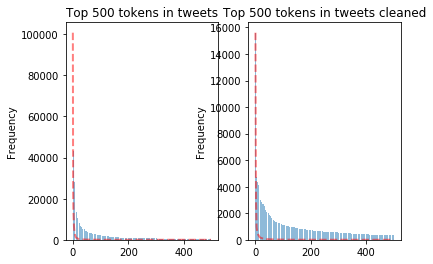

In [94]:
y_pos = np.arange(500)

plt.subplot(121)
expected_zipf = [term_freq_df.sort_values(by='total', ascending=False)['total'][i]/(i+1) for i in y_pos]
plt.bar(y_pos, term_freq_df.sort_values(by='total', ascending=False)['total'][:500], align='center', alpha=0.5)
plt.plot(y_pos, expected_zipf, color='r', linestyle='--',linewidth=2,alpha=0.5)
plt.ylabel('Frequency')
plt.title('Top 500 tokens in tweets')


plt.subplot(122)
expected_zipf = [term_freq_df2.sort_values(by='total', ascending=False)['total'][i]/(i+1) for i in y_pos]
plt.bar(y_pos, term_freq_df2.sort_values(by='total', ascending=False)['total'][:500], align='center', alpha=0.5)
plt.plot(y_pos, expected_zipf, color='r', linestyle='--',linewidth=2,alpha=0.5)
plt.ylabel('Frequency')
plt.title('Top 500 tokens in tweets cleaned')
plt.show()


Taking the log-scale for the frequencies gives us a nice line. To make it more informative we added terms that occur in each segment

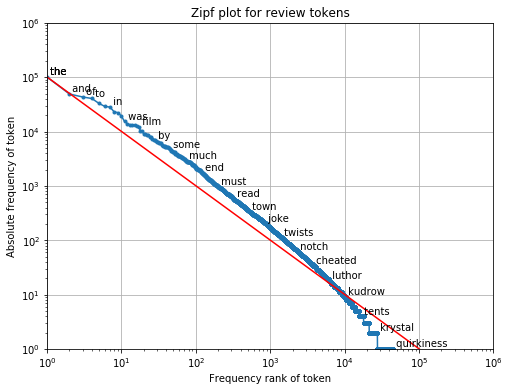

In [96]:
from pylab import *
counts = term_freq_df.total
tokens = term_freq_df.index

ranks = arange(1, len(counts)+1)
indices = argsort(-counts)
frequencies = counts[indices]
plt.figure(figsize=(8,6))
plt.ylim(1,10**6)
plt.xlim(1,10**6)
loglog(ranks, frequencies, marker=".")
plt.plot([1,frequencies[0]],[frequencies[0],1],color='r')
title("Zipf plot for review tokens")
xlabel("Frequency rank of token")
ylabel("Absolute frequency of token")
grid(True)
for n in list(logspace(-0.5, log10(len(counts)-2), 25).astype(int)):
    dummy = text(ranks[n], frequencies[n], " " + tokens[indices[n]], 
                 verticalalignment="bottom",
                 horizontalalignment="left")

Same for more strictly cleared data 

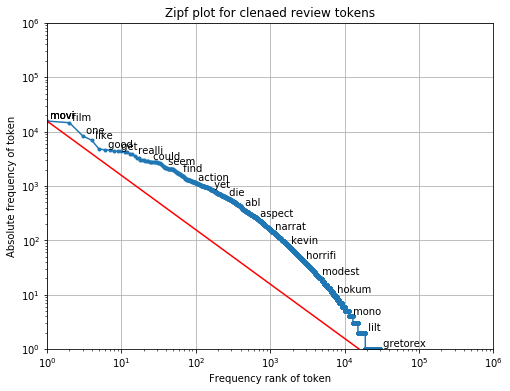

In [97]:
counts = term_freq_df2.total
tokens = term_freq_df2.index

ranks = arange(1, len(counts)+1)
indices = argsort(-counts)
frequencies = counts[indices]
plt.figure(figsize=(8,6))
plt.ylim(1,10**6)
plt.xlim(1,10**6)
loglog(ranks, frequencies, marker=".")
plt.plot([1,frequencies[0]],[frequencies[0],1],color='r')
title("Zipf plot for clenaed review tokens")
xlabel("Frequency rank of token")
ylabel("Absolute frequency of token")
grid(True)
for n in list(logspace(-0.5, log10(len(counts)-2), 25).astype(int)):
    dummy = text(ranks[n], frequencies[n], " " + tokens[indices[n]], 
                 verticalalignment="bottom",
                 horizontalalignment="left")

# Further calculation of ratios 

To get as much information as possible we tried different ratios and means. Table below shows the outcome of different calculations and ratios made on negative and positive sentiments

In [124]:
term_freq_df.head()

negative  positive  total
aa                  1         1      2
aaa                 1         2      3
aaaaah              1         0      1
aaaahhhhhhh         1         0      1
aaah                1         0      1

In [139]:
from scipy.stats import hmean
from scipy.stats import norm
def normcdf(x):
    return norm.cdf(x, x.mean(), x.std())


In [142]:
#pos_rate = positive_frequancy/(positive + negative) 
term_freq_df['pos_rate'] = term_freq_df['positive'] /term_freq_df['total']
term_freq_df['neg_rate'] = term_freq_df['negative'] /term_freq_df['total']
# positive/sum(positive)
term_freq_df['pos_freq_pct'] = term_freq_df['positive'] /term_freq_df['positive'].sum()
term_freq_df['neg_freq_pct'] = term_freq_df['negative'] /term_freq_df['negative'].sum()
#harmonic mean
term_freq_df['pos_hmean'] = term_freq_df.apply(lambda x: (hmean([x['pos_rate'], x['pos_freq_pct']])if x['pos_rate'] > 0 and x['pos_freq_pct'] > 0 else 0), axis=1)
term_freq_df['neg_hmean'] = term_freq_df.apply(lambda x: (hmean([x['neg_rate'], x['neg_freq_pct']])if x['neg_rate'] > 0 and x['neg_freq_pct'] > 0 else 0), axis=1)
#norm cdf 
term_freq_df['pos_rate_normcdf'] = normcdf(term_freq_df['pos_rate'])
term_freq_df['pos_freq_pct_normcdf'] = normcdf(term_freq_df['pos_freq_pct'])
term_freq_df['pos_normcdf_hmean'] = hmean([term_freq_df['pos_rate_normcdf'], term_freq_df['pos_freq_pct_normcdf']])
term_freq_df['neg_rate_normcdf'] = normcdf(term_freq_df['neg_rate'])
term_freq_df['neg_freq_pct_normcdf'] = normcdf(term_freq_df['neg_freq_pct'])
term_freq_df['neg_normcdf_hmean'] = hmean([term_freq_df['neg_rate_normcdf'], term_freq_df['neg_freq_pct_normcdf']])

term_freq_df2['pos_rate'] = term_freq_df2['positive'] /term_freq_df2['total']
term_freq_df2['neg_rate'] = term_freq_df2['negative'] /term_freq_df2['total']
term_freq_df2['pos_freq_pct'] = term_freq_df2['positive'] /term_freq_df2['positive'].sum()
term_freq_df2['neg_freq_pct'] = term_freq_df2['negative'] /term_freq_df2['negative'].sum()
term_freq_df2['pos_hmean'] = term_freq_df2.apply(lambda x: (hmean([x['pos_rate'], x['pos_freq_pct']])if x['pos_rate'] > 0 and x['pos_freq_pct'] > 0 else 0), axis=1)
term_freq_df2['neg_hmean'] = term_freq_df2.apply(lambda x: (hmean([x['neg_rate'], x['neg_freq_pct']])if x['neg_rate'] > 0 and x['neg_freq_pct'] > 0 else 0), axis=1)
term_freq_df2['pos_rate_normcdf'] = normcdf(term_freq_df2['pos_rate'])
term_freq_df2['pos_freq_pct_normcdf'] = normcdf(term_freq_df2['pos_freq_pct'])
term_freq_df2['pos_normcdf_hmean'] = hmean([term_freq_df2['pos_rate_normcdf'], term_freq_df2['pos_freq_pct_normcdf']])
term_freq_df2['neg_rate_normcdf'] = normcdf(term_freq_df2['neg_rate'])
term_freq_df2['neg_freq_pct_normcdf'] = normcdf(term_freq_df2['neg_freq_pct'])
term_freq_df2['neg_normcdf_hmean'] = hmean([term_freq_df2['neg_rate_normcdf'], term_freq_df2['neg_freq_pct_normcdf']])


multi_table([term_freq_df.sort_values(by='pos_freq_pct', ascending=False).iloc[:10],term_freq_df2.sort_values(by='pos_freq_pct', ascending=False).iloc[:10]])

Text(0.5, 1.0, 'neg_normcdf_hmean vs pos_normcdf_hmean')

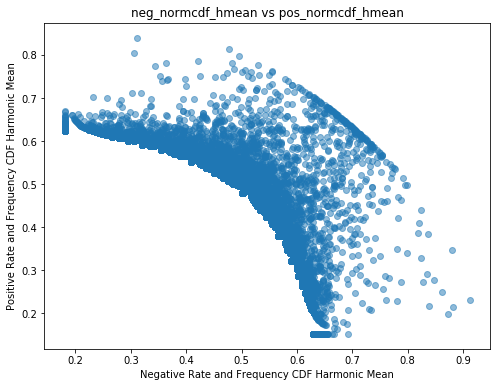

In [150]:
plt.figure(figsize=(8,6))
ax = sns.regplot(x="neg_normcdf_hmean", y="pos_normcdf_hmean",fit_reg=False, scatter_kws={'alpha':0.5},data=term_freq_df)
plt.ylabel('Positive Rate and Frequency CDF Harmonic Mean')
plt.xlabel('Negative Rate and Frequency CDF Harmonic Mean')
plt.title('neg_normcdf_hmean vs pos_normcdf_hmean')

Plot of the harmonic mean of rate CDF and frequency CDF (for less cleaned data).    
If a point is closer to the upper left corner, it is more positive, and if it is closer to the bottom right corner, it is more negative.

Text(0.5, 1.0, 'neg_normcdf_hmean vs pos_normcdf_hmean')

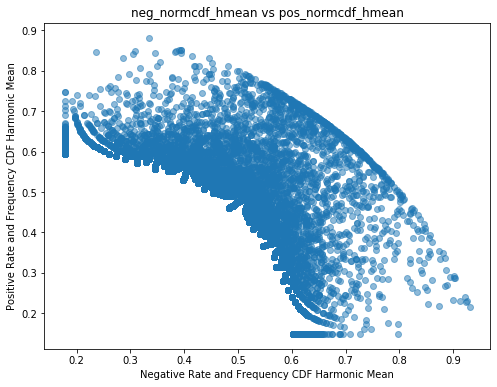

In [145]:
plt.figure(figsize=(8,6))
ax = sns.regplot(x="neg_normcdf_hmean", y="pos_normcdf_hmean",fit_reg=False, scatter_kws={'alpha':0.5},data=term_freq_df2)
plt.ylabel('Positive Rate and Frequency CDF Harmonic Mean')
plt.xlabel('Negative Rate and Frequency CDF Harmonic Mean')
plt.title('neg_normcdf_hmean vs pos_normcdf_hmean')

Plot of the harmonic mean of rate CDF and frequency CDF (for cleaned data).    
In both cases, it has created an interesting, almost symmetrical shape.

In [147]:
from bokeh.plotting import figure,output_file,show
from bokeh.io import output_notebook, show
from bokeh.models import LinearColorMapper
from bokeh.models import HoverTool

Now the funniest part of ratio analysis.  We created an interactive plot with the usage of BokehJS. All points indicate a word that meaning can be checkedby pointing the cursor at it.

In [148]:
output_notebook()

Loading BokehJS ...

In [151]:
color_mapper = LinearColorMapper(palette='Inferno256', low=min(term_freq_df.pos_normcdf_hmean), high=max(term_freq_df.pos_normcdf_hmean))
p = figure(x_axis_label='neg_normcdf_hmean', y_axis_label='pos_normcdf_hmean')
p.circle('neg_normcdf_hmean','pos_normcdf_hmean',size=5,alpha=0.3,source=term_freq_df2,color={'field': 'pos_normcdf_hmean', 'transform': color_mapper})
hover = HoverTool(tooltips=[('token','@index')])
p.add_tools(hover)
show(p)

## Testing models on our dataset

After some data exploration, it is time to set hyperparameters for our model. We will take on the workshop which approach of cleaning text is most effective, how many words to use and what is better for data vectorisation (CountVectorizer vs Tfidf). Ngrams also will be taken into account, for each method.

In [108]:
#clean_df.columns
#clean_df.shape #(7501,3)

In [11]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from time import time
from sklearn.model_selection import train_test_split

We divided our dataset into the train and test set (in proportions 80:20). In both sets, there are about 50% of negative words and 50% of positive words.

In [12]:
x = clean_df.text
y = clean_df.target

SEED = 2020
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2, random_state=SEED)
print(f"Train test has {len(x_train)} etries where negative are {(len(x_train[y_train == 0])/len(x_train)) * 100}% \n and positive {(len(x_train[y_train == 1])/len(x_train)) * 100}% \n")
print(f"Test set has {len(x_test)} etries where negative are {(len(x_test[y_test== 0])/len(x_test)) * 100}% \n and positive {(len(x_test[y_test== 1])/len(x_test)) * 100}% \n")


Train test has 6000 etries where negative are 50.66666666666667% 
 and positive 49.333333333333336% 

Test set has 1501 etries where negative are 49.43371085942705% 
 and positive 50.56628914057295% 



In [13]:
def accuracy(pipeline,x_train,y_train,x_test,y_test):
    
    t0 = time()
    sentiment_fit = pipeline.fit(x_train, y_train)
    #accuracy_train = pipeline.score(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    train_test_time = time() - t0
    
    accuracy = accuracy_score(y_test, y_pred)

    print(f"Accuracy on test data {accuracy} \n")
    
    print(f"train and test time {train_test_time } ")
    print("-"*85)
    return accuracy, train_test_time

In [14]:
countVectorizer = CountVectorizer() 
countVectorizer2 = CountVectorizer(analyzer = clean_text) 
countVector = countVectorizer.fit_transform(clean_df['text'])
countVector2 = countVectorizer2.fit_transform(clean_df['text'])
lr = LogisticRegression()


In [109]:
#[len(countVectorizer.get_feature_names()),len(countVectorizer2.get_feature_names())]

In [17]:
n_features = np.arange(5000,50001,5000)
def nfeature_accuracy_checker(vectorizer=countVectorizer, n_features=n_features, stop_words=None, ngram_range=(1, 1), classifier=lr,analyzer = 'word'):
    
    result = []
    print(classifier,'\n')
    for n in n_features:
        vectorizer.set_params(stop_words=stop_words, max_features=n, ngram_range=ngram_range,analyzer = analyzer)
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', classifier)
        ])
        nfeature_accuracy,tt_time = accuracy(checker_pipeline, x_train, y_train, x_test, y_test)
        result.append((n,nfeature_accuracy,tt_time))
    
    return result 

In [18]:
feat_tun_nochanges = nfeature_accuracy_checker()
feat_tun_nochanges_df = pd.DataFrame(feat_tun_nochanges,columns =['nfeatures','validation_accuracy','train_test_time'])


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False) 



/Users/czoppson/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy on test data 0.8374417055296469 

train and test time 2.453404188156128 
-------------------------------------------------------------------------------------
Accuracy on test data 0.8414390406395736 

train and test time 2.5388221740722656 
-------------------------------------------------------------------------------------
Accuracy on test data 0.8461025982678214 

train and test time 2.7773897647857666 
-------------------------------------------------------------------------------------
Accuracy on test data 0.8454363757495004 

train and test time 3.0920920372009277 
-------------------------------------------------------------------------------------
Accuracy on test data 0.8454363757495004 

train and test time 2.843268871307373 
-------------------------------------------------------------------------------------
Accuracy on test data 0.8454363757495004 

train and test time 2.832051992416382 
---------------------------------------------------------------------------

In [19]:
feat_tun_stop_words = nfeature_accuracy_checker(stop_words='english')
feat_tun_stop_words_df = pd.DataFrame(feat_tun_stop_words,columns =['nfeatures','validation_accuracy','train_test_time'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False) 

Accuracy on test data 0.8414390406395736 

train and test time 1.6678590774536133 
-------------------------------------------------------------------------------------
Accuracy on test data 0.8427714856762158 

train and test time 1.7214748859405518 
-------------------------------------------------------------------------------------
Accuracy on test data 0.8481012658227848 

train and test time 1.7542762756347656 
-------------------------------------------------------------------------------------
Accuracy on test data 0.8507661558960693 

train and test time 1.8164401054382324 
-------------------------------------------------------------------------------------
Accuracy on test data 0.8527648234510327 

train and test 

In [20]:
feat_tun_full_clean= nfeature_accuracy_checker(analyzer = clean_text)
feat_tun_full_clean_df = pd.DataFrame(feat_tun_full_clean,columns =['nfeatures','validation_accuracy','train_test_time'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False) 

Accuracy on test data 0.8381079280479681 

train and test time 31.23216199874878 
-------------------------------------------------------------------------------------
Accuracy on test data 0.8414390406395736 

train and test time 32.51610493659973 
-------------------------------------------------------------------------------------
Accuracy on test data 0.8461025982678214 

train and test time 34.914398193359375 
-------------------------------------------------------------------------------------
Accuracy on test data 0.8474350433044637 

train and test time 33.38447594642639 
-------------------------------------------------------------------------------------
Accuracy on test data 0.8454363757495004 

train and test tim

Explanation about legend: 'full cleaned data' are reviews from 'text2' column, 'with stop words' is connected with reviews from column "text", ' 'no stop words' are also taken from "text" column but as name states, we deleted stop words.

### Logistic regression + unigram

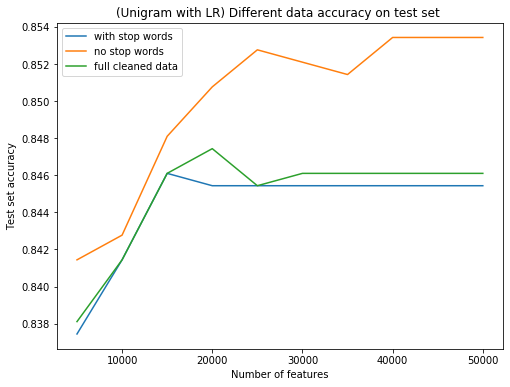

In [110]:
plt.figure(figsize=(8,6))
plt.plot(feat_tun_nochanges_df.nfeatures,feat_tun_nochanges_df.validation_accuracy,label = 'with stop words')
plt.plot(feat_tun_stop_words_df.nfeatures,feat_tun_stop_words_df.validation_accuracy,label = 'no stop words')
plt.plot(feat_tun_full_clean_df.nfeatures,feat_tun_full_clean_df.validation_accuracy,label = 'full cleaned data')
plt.xlabel("Number of features")
plt.ylabel("Test set accuracy")
plt.title("(Unigram with LR) Different data accuracy on test set ")
plt.legend()


We've compared accuracy on the test set of different data: with stop words, without stop words and cleaned one. It is clearly seen in the plot that data without stop words has the highest accuracy. What is more, there is no difference if we take 40000 or 50000 number of features.

In [22]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
feat_tun_nochanges_nb = nfeature_accuracy_checker(classifier=nb)
feat_tun_nochanges_nb_df = pd.DataFrame(feat_tun_nochanges_nb,columns =['nfeatures','validation_accuracy','train_test_time'])

feat_tun_stop_words_nb = nfeature_accuracy_checker(stop_words='english',classifier=nb)
feat_tun_stop_words_nb_df = pd.DataFrame(feat_tun_stop_words_nb,columns =['nfeatures','validation_accuracy','train_test_time'])

feat_tun_full_clean_nb= nfeature_accuracy_checker(analyzer = clean_text,classifier=nb)
feat_tun_full_clean_nb_df = pd.DataFrame(feat_tun_full_clean_nb,columns =['nfeatures','validation_accuracy','train_test_time'])


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True) 

Accuracy on test data 0.8127914723517655 

train and test time 1.6197948455810547 
-------------------------------------------------------------------------------------
Accuracy on test data 0.8121252498334444 

train and test time 1.5243289470672607 
-------------------------------------------------------------------------------------
Accuracy on test data 0.8107928047968022 

train and test time 1.6061468124389648 
-------------------------------------------------------------------------------------
Accuracy on test data 0.8181212524983345 

train and test time 1.6371440887451172 
-------------------------------------------------------------------------------------
Accuracy on test data 0.8187874750166556 

train and test time 2.0093698501586914 
-------------------------------------------------------------------------------------
Accuracy on test data 0.8174550299800133 

train and test time 1.8617231845855713 
-----------

### Naive Bayes + unigram

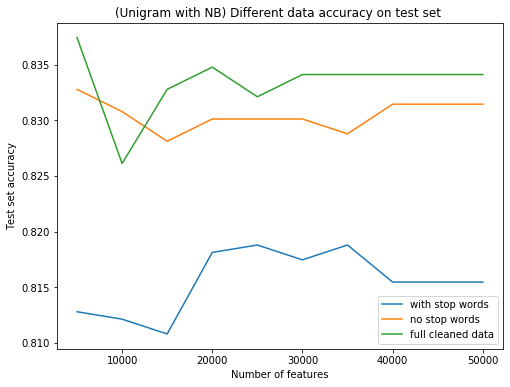

In [111]:
plt.figure(figsize=(8,6))
plt.plot(feat_tun_nochanges_nb_df.nfeatures,feat_tun_nochanges_nb_df.validation_accuracy,label = 'with stop words')
plt.plot(feat_tun_stop_words_nb_df.nfeatures,feat_tun_stop_words_nb_df.validation_accuracy,label = 'no stop words')
plt.plot(feat_tun_full_clean_nb_df.nfeatures,feat_tun_full_clean_nb_df.validation_accuracy,label = 'full cleaned data')
plt.xlabel("Number of features")
plt.ylabel("Test set accuracy")
plt.title("(Unigram with NB) Different data accuracy on test set ")
plt.legend()

In case of NB, the accuracy is the highest for the full cleaned data. The results for data with stopwords are definitely worse. But the difference between cleaned data and data without stop words is not relevant. Thus, in further steps, we won't use full cleaning - it isn't worthwile.

In [24]:
feature_tune_bg_lr = nfeature_accuracy_checker(ngram_range=(1, 2),stop_words='english')
feature_tune_tg_lr = nfeature_accuracy_checker(ngram_range=(1, 3),stop_words='english')
feature_tune_fog_lr = nfeature_accuracy_checker(ngram_range=(1, 4),stop_words='english')
feature_tune_fig_lr = nfeature_accuracy_checker(ngram_range=(1, 5),stop_words='english')
feature_tune_sg_lr = nfeature_accuracy_checker(ngram_range=(1, 6),stop_words='english')

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False) 



/Users/czoppson/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy on test data 0.8427714856762158 

train and test time 5.124621152877808 
-------------------------------------------------------------------------------------
Accuracy on test data 0.8467688207861426 

train and test time 5.614950895309448 
-------------------------------------------------------------------------------------
Accuracy on test data 0.8507661558960693 

train and test time 5.051954030990601 
-------------------------------------------------------------------------------------
Accuracy on test data 0.8507661558960693 

train and test time 5.431401014328003 
-------------------------------------------------------------------------------------
Accuracy on test data 0.8520986009327115 

train and test time 5.576926946640015 
-------------------------------------------------------------------------------------
Accuracy on test data 0.8534310459693538 

train and test time 5.35313606262207 
-------------------------------------------------------------------------------

Accuracy on test data 0.8540972684876749 

train and test time 21.78284192085266 
-------------------------------------------------------------------------------------
Accuracy on test data 0.854763491005996 

train and test time 19.01121997833252 
-------------------------------------------------------------------------------------
Accuracy on test data 0.8560959360426382 

train and test time 18.73910403251648 
-------------------------------------------------------------------------------------
Accuracy on test data 0.8560959360426382 

train and test time 21.683395862579346 
-------------------------------------------------------------------------------------
Accuracy on test data 0.8554297135243171 

train and test time 21.442890167236328 
-------------------------------------------------------------------------------------
Accuracy on test data 0.8540972684876749 

train and test time 19.58430314064026 
-----------------------------------------------------------------------------

### Comparison of 1-6grams on the data without stopwords + logistic regression

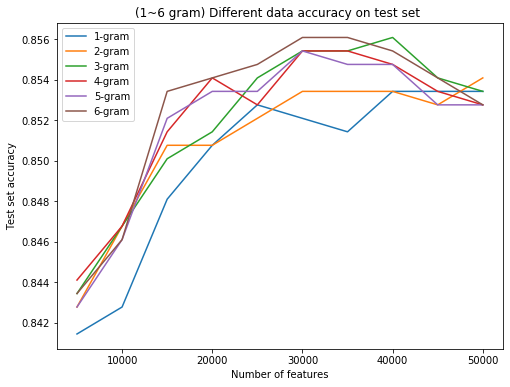

In [112]:
feature_tune_bg_lr_pd = pd.DataFrame(feature_tune_bg_lr,columns=['nfeatures','validation_accuracy','train_test_time'])
feature_tune_tg_lr_pd = pd.DataFrame(feature_tune_tg_lr,columns=['nfeatures','validation_accuracy','train_test_time'])
feature_tune_fog_lr_pd = pd.DataFrame(feature_tune_fog_lr,columns=['nfeatures','validation_accuracy','train_test_time'])
feature_tune_fig_lr_pd = pd.DataFrame(feature_tune_fig_lr,columns=['nfeatures','validation_accuracy','train_test_time'])
feature_tune_sg_lr_pd = pd.DataFrame(feature_tune_sg_lr,columns=['nfeatures','validation_accuracy','train_test_time'])


plt.figure(figsize=(8,6))
plt.plot(feat_tun_stop_words_df.nfeatures,feat_tun_stop_words_df.validation_accuracy,label = '1-gram')
plt.plot(feature_tune_bg_lr_pd.nfeatures,feature_tune_bg_lr_pd.validation_accuracy,label = '2-gram')
plt.plot(feature_tune_tg_lr_pd.nfeatures,feature_tune_tg_lr_pd.validation_accuracy,label = '3-gram')
plt.plot(feature_tune_fog_lr_pd.nfeatures,feature_tune_fog_lr_pd.validation_accuracy,label = '4-gram')
plt.plot(feature_tune_fig_lr_pd.nfeatures,feature_tune_fig_lr_pd.validation_accuracy,label = '5-gram')
plt.plot(feature_tune_sg_lr_pd.nfeatures,feature_tune_sg_lr_pd.validation_accuracy,label = '6-gram')
plt.xlabel("Number of features")
plt.ylabel("Test set accuracy")
plt.title("(1~6 gram) Different data accuracy on test set ")
plt.legend()

It's clearly visible that there aren't big differences between the methods. We also see that above 40000 there is a slight decrease so there is probably no point to use more than 40k features. Using ngrams longer than 3 seems to be pointless but we will take this hypotheis on the workshop in upcoming simulations

In [29]:
feature_tune_bg_nb = nfeature_accuracy_checker(ngram_range=(1, 2),stop_words='english',classifier=nb)
feature_tune_tg_nb = nfeature_accuracy_checker(ngram_range=(1, 3),stop_words='english',classifier=nb)
feature_tune_fog_nb = nfeature_accuracy_checker(ngram_range=(1, 4),stop_words='english',classifier=nb)
feature_tune_fig_nb = nfeature_accuracy_checker(ngram_range=(1, 5),stop_words='english',classifier=nb)
feature_tune_sg_nb = nfeature_accuracy_checker(ngram_range=(1, 6),stop_words='english',classifier=nb)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True) 

Accuracy on test data 0.8301132578281146 

train and test time 5.507316827774048 
-------------------------------------------------------------------------------------
Accuracy on test data 0.8421052631578947 

train and test time 5.575562000274658 
-------------------------------------------------------------------------------------
Accuracy on test data 0.843437708194537 

train and test time 5.545675992965698 
-------------------------------------------------------------------------------------
Accuracy on test data 0.8461025982678214 

train and test time 5.062522888183594 
-------------------------------------------------------------------------------------
Accuracy on test data 0.8454363757495004 

train and test time 4.723773956298828 
-------------------------------------------------------------------------------------
Accuracy on test data 0.8474350433044637 

train and test time 4.602075099945068 
------------------

Accuracy on test data 0.8500999333777481 

train and test time 20.542494297027588 
-------------------------------------------------------------------------------------
Accuracy on test data 0.8514323784143905 

train and test time 19.230464935302734 
-------------------------------------------------------------------------------------
Accuracy on test data 0.8520986009327115 

train and test time 19.24128007888794 
-------------------------------------------------------------------------------------


### Comparison of 1-6grams on the data without stopwords + Naive Bayes

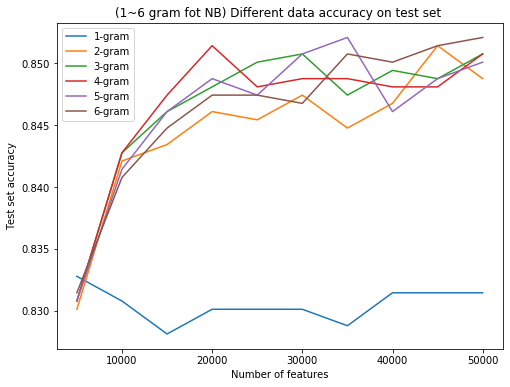

In [113]:
feature_tune_bg_nb_pd = pd.DataFrame(feature_tune_bg_nb,columns=['nfeatures','validation_accuracy','train_test_time'])
feature_tune_tg_nb_pd = pd.DataFrame(feature_tune_tg_nb,columns=['nfeatures','validation_accuracy','train_test_time'])
feature_tune_fog_nb_pd = pd.DataFrame(feature_tune_fog_nb,columns=['nfeatures','validation_accuracy','train_test_time'])
feature_tune_fig_nb_pd = pd.DataFrame(feature_tune_fig_nb,columns=['nfeatures','validation_accuracy','train_test_time'])
feature_tune_sg_nb_pd = pd.DataFrame(feature_tune_sg_nb,columns=['nfeatures','validation_accuracy','train_test_time'])


plt.figure(figsize=(8,6))
plt.plot(feat_tun_stop_words_nb_df.nfeatures,feat_tun_stop_words_nb_df.validation_accuracy,label = '1-gram')
plt.plot(feature_tune_bg_nb_pd.nfeatures,feature_tune_bg_nb_pd.validation_accuracy,label = '2-gram')
plt.plot(feature_tune_tg_nb_pd.nfeatures,feature_tune_tg_nb_pd.validation_accuracy,label = '3-gram')
plt.plot(feature_tune_fog_nb_pd.nfeatures,feature_tune_fog_nb_pd.validation_accuracy,label = '4-gram')
plt.plot(feature_tune_fig_nb_pd.nfeatures,feature_tune_fig_nb_pd.validation_accuracy,label = '5-gram')
plt.plot(feature_tune_sg_nb_pd.nfeatures,feature_tune_sg_nb_pd.validation_accuracy,label = '6-gram')
plt.xlabel("Number of features")
plt.ylabel("Test set accuracy")
plt.title("(1~6 gram fot NB) Different data accuracy on test set ")
plt.legend()

This time, unigram has definitely worse results, but all the other methods look almost similar. As we see using unigrams and NB are not coming together. For other ngrams NB is performing almost as good as logistic regression.

### Comparison of TFIDF and CountVectorizer (Logistic regression)

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfdf = TfidfVectorizer()

In [33]:
feature_tune_tf_ug  = nfeature_accuracy_checker(vectorizer = tfdf ,stop_words='english')
feature_tune_tf_tg = nfeature_accuracy_checker(vectorizer = tfdf ,stop_words='english',ngram_range = (1, 3))
feature_tune_tf_sg  = nfeature_accuracy_checker(vectorizer = tfdf ,stop_words='english',ngram_range = (1, 6))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False) 



/Users/czoppson/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy on test data 0.8540972684876749 

train and test time 1.6181609630584717 
-------------------------------------------------------------------------------------
Accuracy on test data 0.8514323784143905 

train and test time 1.5902228355407715 
-------------------------------------------------------------------------------------
Accuracy on test data 0.8514323784143905 

train and test time 1.4468309879302979 
-------------------------------------------------------------------------------------
Accuracy on test data 0.8520986009327115 

train and test time 1.4512436389923096 
-------------------------------------------------------------------------------------
Accuracy on test data 0.8534310459693538 

train and test time 1.6570608615875244 
-------------------------------------------------------------------------------------
Accuracy on test data 0.8527648234510327 

train and test time 1.8020961284637451 
------------------------------------------------------------------------

In [34]:
feature_tune_tf_ug_pd = pd.DataFrame(feature_tune_tf_ug,columns=['nfeatures','validation_accuracy','train_test_time'])
feature_tune_tf_tg_pd = pd.DataFrame(feature_tune_tf_tg ,columns=['nfeatures','validation_accuracy','train_test_time'])
feature_tune_tf_sg_pd = pd.DataFrame(feature_tune_tf_sg ,columns=['nfeatures','validation_accuracy','train_test_time'])

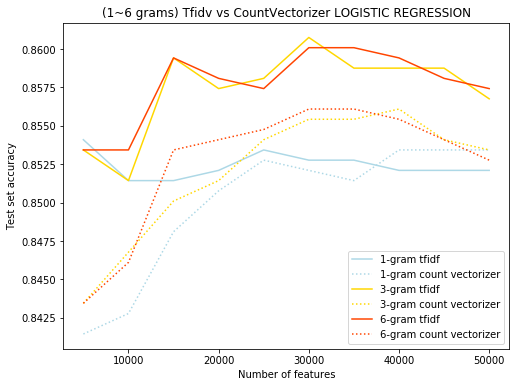

In [35]:
plt.figure(figsize=(8,6))
plt.plot(feature_tune_tf_ug_pd.nfeatures,feature_tune_tf_ug_pd.validation_accuracy,label='1-gram tfidf',color = 'lightblue')
plt.plot(feat_tun_stop_words_df.nfeatures,feat_tun_stop_words_df.validation_accuracy,label = '1-gram count vectorizer',linestyle = ':',color = 'lightblue')
plt.plot(feature_tune_tf_tg_pd.nfeatures,feature_tune_tf_tg_pd.validation_accuracy,label='3-gram tfidf',color = 'gold')
plt.plot(feature_tune_tg_lr_pd.nfeatures,feature_tune_tg_lr_pd.validation_accuracy,label = '3-gram count vectorizer',linestyle = ':',color = 'gold')
plt.plot(feature_tune_tf_sg_pd.nfeatures,feature_tune_tf_sg_pd.validation_accuracy,label='6-gram tfidf',color = 'orangered')
plt.plot(feature_tune_sg_lr_pd.nfeatures,feature_tune_sg_lr_pd.validation_accuracy,label = '6-gram count vectorizer',linestyle = ':',color = 'orangered')
plt.xlabel("Number of features")
plt.ylabel("Test set accuracy")
plt.title('(1~6 grams) Tfidv vs CountVectorizer LOGISTIC REGRESSION')
plt.legend()

Dotted plots are responding to TFIDF and line plots to CountVectorizer. Definitely, TFIDF works better on our dataset. Once again unigram has worse result, whereas 3-gram and 6-gram work the best, again taking all 50k features seems to be pointless

### Comparison of TFIDF and CountVectorizer (Naive Bayes)

In [36]:


feature_tune_tf_ug_nb  = nfeature_accuracy_checker(vectorizer = tfdf ,stop_words='english',classifier=nb)
feature_tune_tf_tg_nb = nfeature_accuracy_checker(vectorizer = tfdf ,stop_words='english',ngram_range = (1, 3),classifier=nb)
feature_tune_tf_sg_nb  = nfeature_accuracy_checker(vectorizer = tfdf ,stop_words='english',ngram_range = (1, 6),classifier=nb)



MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True) 

Accuracy on test data 0.8361092604930047 

train and test time 2.1811201572418213 
-------------------------------------------------------------------------------------
Accuracy on test data 0.8347768154563624 

train and test time 1.5470530986785889 
-------------------------------------------------------------------------------------
Accuracy on test data 0.8361092604930047 

train and test time 1.5125360488891602 
-------------------------------------------------------------------------------------
Accuracy on test data 0.8334443704197202 

train and test time 1.4958291053771973 
-------------------------------------------------------------------------------------
Accuracy on test data 0.8294470353097935 

train and test time 1.630141019821167 
-------------------------------------------------------------------------------------
Accuracy on test data 0.8281145902731513 

train and test time 1.8499689102172852 
------------

In [37]:
feature_tune_tf_ug_nb_pd = pd.DataFrame(feature_tune_tf_ug_nb,columns=['nfeatures','validation_accuracy','train_test_time'])
feature_tune_tf_tg_nb_pd = pd.DataFrame(feature_tune_tf_tg_nb ,columns=['nfeatures','validation_accuracy','train_test_time'])
feature_tune_tf_sg_nb_pd = pd.DataFrame(feature_tune_tf_sg_nb ,columns=['nfeatures','validation_accuracy','train_test_time'])

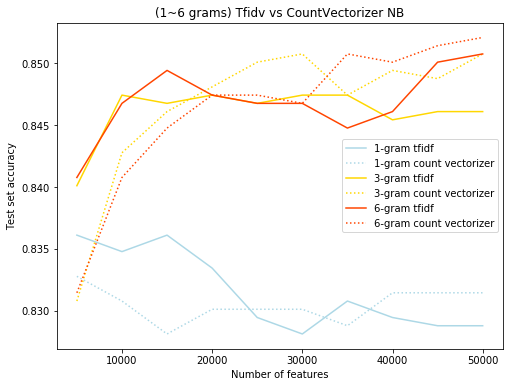

In [38]:
plt.figure(figsize=(8,6))
plt.plot(feature_tune_tf_ug_nb_pd.nfeatures,feature_tune_tf_ug_nb_pd.validation_accuracy,label='1-gram tfidf',color = 'lightblue')
plt.plot(feat_tun_stop_words_nb_df.nfeatures,feat_tun_stop_words_nb_df.validation_accuracy,label = '1-gram count vectorizer',linestyle = ':',color = 'lightblue')
plt.plot(feature_tune_tf_tg_nb_pd.nfeatures,feature_tune_tf_tg_nb_pd.validation_accuracy,label='3-gram tfidf',color = 'gold')
plt.plot(feature_tune_tg_nb_pd.nfeatures,feature_tune_tg_nb_pd.validation_accuracy,label = '3-gram count vectorizer',linestyle = ':',color = 'gold')
plt.plot(feature_tune_tf_sg_nb_pd.nfeatures,feature_tune_tf_sg_nb_pd.validation_accuracy,label='6-gram tfidf',color = 'orangered')
plt.plot(feature_tune_sg_nb_pd.nfeatures,feature_tune_sg_nb_pd.validation_accuracy,label = '6-gram count vectorizer',linestyle = ':',color = 'orangered')
plt.xlabel("Number of features")
plt.ylabel("Test set accuracy")
plt.title('(1~6 grams) Tfidv vs CountVectorizer NB')
plt.legend()

For the NB classifier, unigrams look definitely worse in both cases. All the other methods work almost the same. Thus, taking into account this plot and the previous one, we will only consider 3-gram TFIDF in further analysis.

### Logistic regression and words that make biggest impact on classification 

Beacause logistic regression is fully interpretable, we took a look at the words that had the highest (positive) and the lowest (negative) estimators for the model.

In [40]:
vectorizer = TfidfVectorizer()
vectorizer.set_params(stop_words='english', ngram_range=(1, 3))
X = vectorizer.fit_transform(x_train)

In [41]:
logistic_regression = LogisticRegression()
logistic_refression = logistic_regression.fit(X,y_train)
words = vectorizer.get_feature_names()
lr_beta = np.ravel(logistic_refression.coef_)

/Users/czoppson/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


#### TOP 100 negative words in sentiment analysis

In [43]:
result_negative = np.argpartition(lr_beta, 100)
words = np.array(words)
words[result_negative[:100]]

array(['horror', 'guy', 'supposed', 'did', 'script', 'minutes', 'movie',
       'waste', 'looks', 'like', 'awful', 'reason', 'save', 'ridiculous',
       'worst movie', 'boring', 'director', 'terrible', 'worst', 'half',
       'better', 'wasted', 'poorly', 'oh', 'dull', 'poor', 'fails', 'bad',
       'pointless', 'annoying', 'money', 'avoid', 'badly', 'crap',
       'waste time', 'lame', 'instead', 'just', 'acting', 'stupid',
       'mess', 'thing', 'plot', 'horrible', 'cheap', 'worse', 'idea',
       'attempt', 'clich', 'garbage', 'pretty', 'gore', 'disappointment',
       'zombie', 'bad movie', 'joke', 'guess', 'killer', 'rest', 'sex',
       'unfortunately', 'movie bad', 'laughable', 'effects',
       'predictable', 'care', 'original', 'low', 'looked', 'interesting',
       'trash', 'make', 'gay', 'trying', 'problem', 'looks like', 'point',
       'bad acting', 'unless', 'lacks', 'effort', 'sorry', 'ok',
       'redeeming', 'unfunny', 'bunch', 'tries', 'unbelievable', 'decent',
    

#### TOP 100 positive words in sentiment analysis

In [129]:
result_positive = np.argpartition(lr_beta, -100)
words[result_positive[-100:]]

array(['right', 'ways', 'chess', 'bourne', 'solid', 'chan', 'humour',
       'war', 'future', 'dvd', 'wonderfully', 'fans', 'lot', 'plays',
       'played', 'incredible', 'powerful', 'favourite', 'stewart',
       'history', 'gives', 'day', 'seen', 'tale', 'unique', 'scared',
       'soundtrack', 'later', 'realistic', 'performance', 'role',
       'outstanding', 'perfectly', 'times', 'makes', 'lives',
       'appreciate', 'recommended', 'young', 'masterpiece', 'touching',
       'refreshing', 'live', 'atmosphere', 'noir', 'father', 'classic',
       'release', 'subtle', 'including', 'story', 'works', 'rare',
       'hilarious', 'moving', 'human', 'delightful', 'surprised',
       'highly', 'superb', 'life', 'world', 'great', 'simple',
       'excellent', 'good', 'family', 'shows', 'think', 'wonderful',
       'brilliant', 'gem', 'definitely', 'fantastic', 'heart',
       'especially', 'years', 'beautiful', 'beautifully', 'perfect',
       'quite', 'job', 'sweet', 'bit', 'nice', 'perfor

Most of the terms that are clustered in groups of certain sentiment make sens. The ones that computer takes as negative would be classified in the same way by a human (in this case by us) - the same happens for positive. It means that our regression makes sense and will probably work properly for other texts.

In [73]:
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.neighbors import NearestCentroid
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_extraction.text import TfidfVectorizer

## Different methods for sentiment classification 

In [90]:
names = ["Logistic Regression", "Linear SVC", "LinearSVC with L1-based feature selection","Multinomial NB", 
         "Bernoulli NB", "Ridge Classifier", "AdaBoost", "Perceptron","Passive-Aggresive", "Nearest Centroid"]

classifiers = [
    LogisticRegression(),
    LinearSVC(),
    Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False))),
  ('classification', LinearSVC(penalty="l2"))]),
    MultinomialNB(),
    BernoulliNB(),
    RidgeClassifier(),
    AdaBoostClassifier(),
    Perceptron(),
    PassiveAggressiveClassifier(),
    NearestCentroid()
    ]
    
zipped_clf = zip(names,classifiers)

tvec = TfidfVectorizer()

In [95]:
def accuracy_2(pipeline,x_train,y_train,x_test,y_test):
    
    t0 = time()
    sentiment_fit = pipeline.fit(x_train, y_train)
    accuracy_test =sentiment_fit.score(x_train, y_train)
    #accuracy_train = pipeline.score(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    train_test_time = time() - t0
    
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"Accuracy on train data {accuracy_test} \n")
    print(f"Accuracy on test data {accuracy} \n")
    
    print(f"train and test time {train_test_time } ")
    print("-"*85)
    return accuracy_test,accuracy,train_test_time

In [97]:
def cls_compare(vectorizer=tvec, n_features=40000, stop_words=None, ngram_range=(1, 1), classifier=zipped_clf):
    result = []
    vectorizer.set_params(stop_words=stop_words, max_features=n_features, ngram_range=ngram_range)
    for n,c in classifier:
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', c)
        ])
        print(f"Validation result for {n}")
        print(c)
        clf_accuracy_test,clf_accuracy,tt_time = accuracy_2(checker_pipeline, x_train, y_train, x_test, y_test)
        result.append((n,clf_accuracy_test,clf_accuracy,tt_time))
    return result

- Perceptron (simple NN with weights)
- Passive-aggresive (adaptive SVC)
- NearestCentroid (knn with means)

In [93]:
cls_outcome = cls_compare(stop_words = 'english',ngram_range=(1, 3))
cls_imdb_score = pd.DataFrame(cls_outcome,columns = ['model','train accuracy','test accuracy','time'])

Validation result for Logistic Regression
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


/Users/czoppson/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy on train data 0.9576666666666667 

Accuracy on test data 0.8587608261159227 

train and test time 10.158351182937622 
-------------------------------------------------------------------------------------
Validation result for Linear SVC
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
Accuracy on train data 0.9995 

Accuracy on test data 0.8734177215189873 

train and test time 10.494400024414062 
-------------------------------------------------------------------------------------
Validation result for LinearSVC with L1-based feature selection
Pipeline(memory=None,
     steps=[('feature_selection', SelectFromModel(estimator=LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l1', random_state=None, tol=

/Users/czoppson/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in Perceptron in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


Accuracy on train data 0.998 

Accuracy on test data 0.832778147901399 

train and test time 12.73625898361206 
-------------------------------------------------------------------------------------
Validation result for Passive-Aggresive
PassiveAggressiveClassifier(C=1.0, average=False, class_weight=None,
              early_stopping=False, fit_intercept=True, loss='hinge',
              max_iter=None, n_iter=None, n_iter_no_change=5, n_jobs=None,
              random_state=None, shuffle=True, tol=None,
              validation_fraction=0.1, verbose=0, warm_start=False)


/Users/czoppson/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in PassiveAggressiveClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


Accuracy on train data 1.0 

Accuracy on test data 0.8647568287808128 

train and test time 14.625783920288086 
-------------------------------------------------------------------------------------
Validation result for Nearest Centroid
NearestCentroid(metric='euclidean', shrink_threshold=None)
Accuracy on train data 0.8543333333333333 

Accuracy on test data 0.8054630246502332 

train and test time 11.883413076400757 
-------------------------------------------------------------------------------------


In [94]:
cls_imdb_score

model  train accuracy  test accuracy  \
0                        Logistic Regression        0.957667       0.858761   
1                                 Linear SVC        0.999500       0.873418   
2  LinearSVC with L1-based feature selection        0.964500       0.852099   
3                             Multinomial NB        0.956833       0.845436   
4                               Bernoulli NB        0.952833       0.846103   
5                           Ridge Classifier        0.997500       0.870087   
6                                   AdaBoost        0.816333       0.760160   
7                                 Perceptron        0.998000       0.832778   
8                          Passive-Aggresive        1.000000       0.864757   
9                           Nearest Centroid        0.854333       0.805463   

        time  
0  10.158351  
1  10.494400  
2  10.559286  
3  10.392213  
4  11.702590  
5  13.869731  
6  16.457215  
7  12.736259  
8  14.625784  
9  11.883413

In [98]:
names = ["Logistic Regression C = 0.2","Logistic Regression C = 3","Logistic Regression L1 regularization, C = 5","Logistic Regression L1 regularization, C = 1", "Linear SVC, C = 0.5", "LinearSVC with L1-based feature selection","Multinomial NB", 
         "Bernoulli NB"]

classifiers = [
    LogisticRegression(C = 0.2),
    LogisticRegression(C = 3),
    LogisticRegression(penalty = 'l1',C = 5),
    LogisticRegression(penalty = 'l1'),
    LinearSVC(C = 0.5),
    Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False))),
  ('classification', LinearSVC(penalty="l2"))]),
    MultinomialNB()
    ]
    
zipped_clf = zip(names,classifiers)

tvec = TfidfVectorizer()

In [100]:
cls_outcome_regulatized = cls_compare(stop_words = 'english',ngram_range=(1, 3))

Validation result for Logistic Regression C = 0.2
LogisticRegression(C=0.2, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


/Users/czoppson/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy on train data 0.9078333333333334 

Accuracy on test data 0.8334443704197202 

train and test time 10.162506103515625 
-------------------------------------------------------------------------------------
Validation result for Logistic Regression C = 3
LogisticRegression(C=3, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
Accuracy on train data 0.9886666666666667 

Accuracy on test data 0.8667554963357762 

train and test time 10.89860200881958 
-------------------------------------------------------------------------------------
Validation result for Logistic Regression L1 regularization, C = 5
LogisticRegression(C=5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, so

In [107]:
cls_imdb_score_regularized = pd.DataFrame(cls_outcome_regulatized,columns = ['model','train accuracy','test accuracy','time'])


Some data has many more features(40k + ) than samples( about 7.5 k ), models tend to overfit. This is exactly the case in our data. Most of the training accuracy is about 100%, it means that our models are trying to fit the train data too much and this may have an impact on a score on the test set. To avoid this scenario we tried to put some additional constraints . We will also play with hyperparameter C that is responsible for extended to which models are trying to fit training data. All results are shown in tables belowe. Right one is presenting models with their default options (only ngrams and max number of features changed), left table is presenting scores on the same train and test set but with different hyperparameters.

In [106]:
multi_table([cls_imdb_score,cls_imdb_score_regularized])

To make a somehow wider conclusion we tried a couple of models and compared their accuracy and time of evaluation. Most of the models have accuracy close or higher than 85% what is positively surprising, because NLP without NN is often useless. In this case, standard models are giving us decent scores in a really short time. Again, logistic regression seems to be one of the best choices. While SVC is performing better, it is not so easy to find the most negative or positive sentences for this classifier. In case of logistic regression, we did it right above. It is good to know that hours spent in the math faculty are not going to be wasted and we can create a simple model that we fully understand and fulfill our requirements about the given task.

In [ ]:
# perception are just weights that x@positive >=0 and x@negative < 0 

In [93]:
#checker_pipeline = Pipeline([
#       ('vectorizer', vectorizer),
#       ('classifier',LogisticRegression() )
#        ])
    
    
#sentiment_fit = checker_pipeline.fit(x_train, y_train)
#y_pred = sentiment_fit.predict(x_test)
#accuracy = accuracy_score(y_test, y_pred)

In [94]:
accuracy

0.8520986009327115

In [121]:
import pytreebank
import sys
import os
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import confusion_matrix

# STANFORD 5 sentiment (SST-5)


To make things more complicated we also tried to work on a data set given by Stanford University.To make this analysis we used the dataset prepared and described for the following [paper](https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf). The hard part of the analysis is the fact that we have 5 classes, where 1 means very negative, 3 - neutral and 5 - very positive. We tried to find out if there is a possibility to create a basic model that will also have a decent outcome on this more sophisticated data. To somehow interpret the models if they match or not certain sentiments, we used confusion matrix and evaluate model according to its outcome.

NOTE: All the data and train-test split were taken from stanford [webside](https://nlp.stanford.edu/sentiment/)

In [117]:
out_path = os.path.join(sys.path[0], 'sst_{}.txt')
dataset = pytreebank.load_sst('./raw_data')

for category in ['train', 'test', 'dev']:
    with open(out_path.format(category), 'w') as outfile:
        for item in dataset[category]:
            outfile.write("__label__{}\t{}\n".format(
                item.to_labeled_lines()[0][0] + 1,
                item.to_labeled_lines()[0][1]
            ))
# Print the length of the training set
#print(len(dataset['train']))

In [118]:
def accuracy_clf(y_pred,y_true):
    "Prediction accuracy (percentage) and F1 score"
    acc = accuracy_score(y_true, y_pred)*100
    f1 = f1_score(y_true,y_pred, average='macro')
    print("Accuracy: {}\nMacro F1-score: {}".format(acc, f1))   

def plot_confusion_matrix(y_true, y_pred, 
                          classes=[1, 2, 3, 4, 5],
                          normalize=False,
                          cmap=plt.cm.YlOrBr):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    (Adapted from scikit-learn docs).
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', origin='lower', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # Show all ticks
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # Label with respective list entries
           xticklabels=classes, yticklabels=classes,
           ylabel='True label',
           xlabel='Predicted label')

    # Set alignment of tick labels
    plt.setp(ax.get_xticklabels(), rotation=0, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    return fig, ax

In [119]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('./sst_train.txt', sep='\t', header=None, names=['truth', 'text'])
df['truth'] = df['truth'].str.replace('__label__', '')
df['truth'] = df['truth'].astype(int).astype('category')
df.head()

truth                                               text
0     4  The Rock is destined to be the 21st Century 's...
1     5  The gorgeously elaborate continuation of `` Th...
2     4  Singer/composer Bryan Adams contributes a slew...
3     3  You 'd think by now America would have had eno...
4     4               Yet the act is still charming here .

Both training and test set are not perfectly balanced in terms of class occurrences, but it shouldn't affect our models in terms of accuracy.

Text(0, 0.5, 'Label')

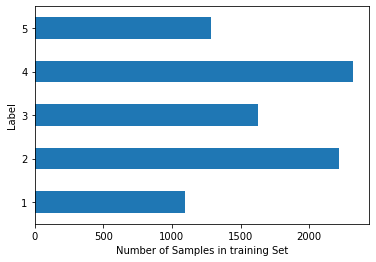

In [123]:
ax = df['truth'].value_counts(sort=False).plot(kind='barh')
ax.set_xlabel("Number of Samples in training Set")
ax.set_ylabel("Label")

In [124]:
df_test = pd.read_csv('./sst_test.txt', sep='\t', header=None, names=['truth', 'text'])
df_test['truth'] = df_test['truth'].str.replace('__label__', '')
df_test['truth'] = df_test['truth'].astype(int).astype('category')


Text(0, 0.5, 'Label')

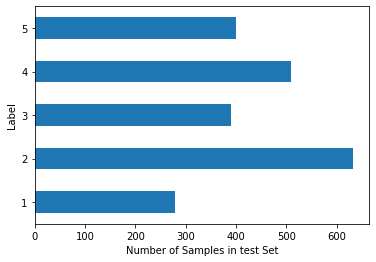

In [125]:
ax = df_test['truth'].value_counts(sort=False).plot(kind='barh')
ax.set_xlabel("Number of Samples in test Set")
ax.set_ylabel("Label")

### Text Blob

In [136]:
from textblob import TextBlob

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x338b46ce10>)

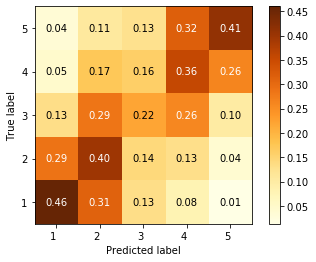

In [137]:
df['score_blob'] = df['text'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['pred_blob'] = pd.cut(df['score_blob'],bins=5, labels=[1, 2, 3, 4, 5])
plot_confusion_matrix(df.pred_blob,df.truth,normalize = True)

In [138]:
accuracy_clf(df.pred_blob,df.truth)

Accuracy: 28.803838951310862
Macro F1-score: 0.23987349627597682


### VADER 

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x338b364b38>)

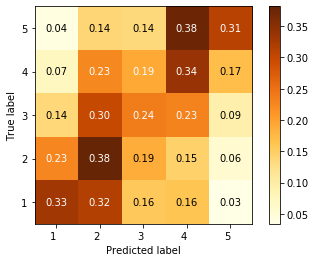

In [139]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
vader = SentimentIntensityAnalyzer()
df['score_vader'] = df['text'].apply(lambda x: vader.polarity_scores(x)['compound'])
df['pred_vader'] = pd.cut(df['score_vader'], bins=5, labels=[1, 2, 3, 4, 5])
plot_confusion_matrix(df.pred_vader,df.truth,normalize = True)

In [140]:
accuracy_clf(df.pred_vader,df.truth)

Accuracy: 30.957397003745317
Macro F1-score: 0.3042290062686328


### LOGISTIC REGRESSION

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a64661be0>)

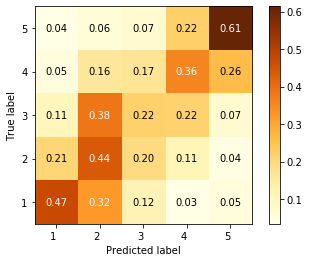

In [126]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import  TfidfTransformer,CountVectorizer,TfidfVectorizer
lr_sentiment_clf = Pipeline([('tfidf', TfidfVectorizer()),
                             ('clf', LogisticRegression(solver='liblinear', multi_class='auto')),])
lr_sentiment_clf = lr_sentiment_clf.fit(df['text'],df['truth'])
df_test['pred_lr'] = lr_sentiment_clf.predict(df_test['text'])
plot_confusion_matrix(df_test.pred_lr,df_test.truth,normalize = True)


In [142]:
accuracy_clf(df_test.pred_lr,df_test.truth)

Accuracy: 40.18099547511312
Macro F1-score: 0.3295860165192341


### SVM 

In [127]:
from sklearn.linear_model import SGDClassifier
svm_sentiment_clf = Pipeline([('vect', CountVectorizer()),
                             ('tfidf', TfidfTransformer()),
                             ('clf', SGDClassifier(
                    loss='hinge',
                    penalty='l2',
                    alpha=1e-3,
                    random_state=42,
                    max_iter=100,
                    learning_rate='optimal',
                    tol=None,
                )),])
svm_sentiment_clf = svm_sentiment_clf.fit(df['text'],df['truth'])
df_test['pred_svm'] = svm_sentiment_clf.predict(df_test['text'])

/Users/czoppson/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a5e382da0>)

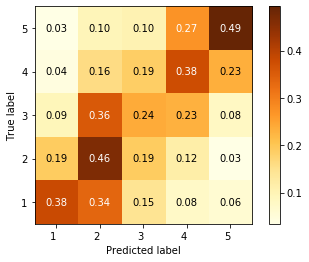

In [128]:
plot_confusion_matrix(df_test.pred_svm,df_test.truth,normalize = True)

In [144]:
accuracy_clf(df_test.pred_svm,df_test.truth)

Accuracy: 41.22171945701357
Macro F1-score: 0.37968831901748645


### Naive Bayes 

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a2436b4e0>)

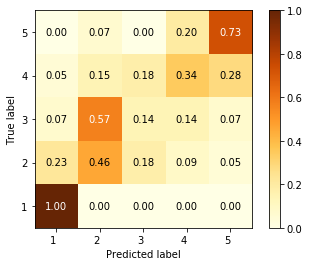

In [145]:
from sklearn.naive_bayes import MultinomialNB
nb_sentiment_clf = Pipeline([
                             ('tfidf', TfidfVectorizer()),
                             ('clf',MultinomialNB()),])
nb_sentiment_clf = nb_sentiment_clf.fit(df['text'],df['truth'])
df_test['pred_nb'] = nb_sentiment_clf.predict(df_test['text'])
plot_confusion_matrix(df_test.pred_nb,df_test.truth,normalize = True)

In [146]:
accuracy_clf(df_test.pred_nb,df_test.truth)

Accuracy: 39.72850678733032
Macro F1-score: 0.22381085722177008


### Conclusion

The logistic regression which is way simpler gave us about 40% and NB 39.7%. They are much easier and interpretable but it is up to us if we want better accuracy or explanation. All models struggle with classes that are close to each other, i.e. {1,2} or {4,5}. There is a lot of misclassification in that case. Neutral class (3) is almost always omitted and classified as 2 or 4. It is hard for a human to find out if a text has irony or if it is neutral, so for these classificators it is simply impossible to make the right decision. It is worth to mention that some models are very accurate for special cases, i.e. NB is perfect in finding very negative and positive comments.

### Sources:
-[Wikipedia](https://nlp.stanford.edu/sentiment/)

-[Towards Data Science](https://towardsdatascience.com/another-twitter-sentiment-analysis-with-python-part-2-333514854913)

-[Kaggle](https://www.kaggle.com/ragnisah/text-data-cleaning-tweets-analysis)

-[Stanford](https://nlp.stanford.edu/sentiment/)